In [3]:
# --- CRITICAL FIX: Downgrade protobuf to avoid TensorFlow conflict on Kaggle T4 ---
# If this cell fails or you still get a 'MessageFactory' error,
# click 'Run > Restart session' and try again.
!pip install -Uq "protobuf~=3.20.0" kagglehub

import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- HARDWARE SETUP ---
# Dual GPU Strategy
try:
    strategy = tf.distribute.MirroredStrategy()
    print(f'GPUs detected: {strategy.num_replicas_in_sync}')
except:
    strategy = tf.distribute.get_strategy()
    print("Dual GPU not detected, using default strategy.")

# Mixed Precision for T4 (speeds up training)
try:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled.")
except:
    pass

print(f"TensorFlow Version: {tf.__version__}")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
GPUs detected: 2
Mixed precision enabled.
TensorFlow Version: 2.18.0


In [4]:
# Download dataset
print("Downloading dataset...")
dataset_path = kagglehub.dataset_download("ishans24/brain-tumor-dataset")
print(f"Path: {dataset_path}")

class Config:
    SEED = 42
    EPOCHS = 40
    # 32 per GPU * 2 = 64 Global Batch Size
    BATCH_SIZE = 32 * strategy.num_replicas_in_sync
    LEARNING_RATE = 1e-4
    # EfficientNetV2S works well with slightly larger inputs
    IMG_SIZE = (300, 300)
    MODEL_PATH = 'best_tumor_model.keras'

print(f"Global Batch Size: {Config.BATCH_SIZE}")

Path: /kaggle/input/brain-tumor-dataset
Global Batch Size: 64


In [5]:
def load_data(data_dir):
    # Define acceptable labels and normalize them
    label_map = {
        'no_tumor': 'notumor', 'notumor': 'notumor',
        'glioma': 'glioma', 'glioma_tumor': 'glioma',
        'meningioma': 'meningioma', 'meningioma_tumor': 'meningioma',
        'pituitary': 'pituitary', 'pituitary_tumor': 'pituitary'
    }
    valid_labels = set(label_map.values())
    file_data = []

    print(f"Scanning {data_dir}...")
    for root, dirs, files in os.walk(data_dir):
        folder = os.path.basename(root).lower()
        # Check if this folder matches any of our label variations
        if folder in label_map:
            standard_label = label_map[folder]
            for f in files:
                if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                    file_data.append({
                        'filepath': os.path.join(root, f),
                        'label': standard_label
                    })

    df = pd.DataFrame(file_data)
    if len(df) == 0:
        raise ValueError("No images found. Check dataset path.")

    # Shuffle
    return df.sample(frac=1, random_state=Config.SEED).reset_index(drop=True)

df = load_data(dataset_path)
print(f"Total images: {len(df)}")
print(df['label'].value_counts())

Scanning /kaggle/input/brain-tumor-dataset...
Total images: 10560
label
glioma        3754
pituitary     2706
meningioma    2343
notumor       1757
Name: count, dtype: int64


In [6]:
# Split 70/15/15
train_df, temp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=Config.SEED)
val_df, test_df = train_test_split(temp, test_size=0.5, stratify=temp['label'], random_state=Config.SEED)

# Augmentation (EfficientNetV2 expects [0-255] range, NO rescale needed here)
train_datagen = ImageDataGenerator(
    rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
    zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
)
test_datagen = ImageDataGenerator()

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label',
    target_size=Config.IMG_SIZE, batch_size=Config.BATCH_SIZE,
    class_mode='categorical', seed=Config.SEED
)
val_gen = test_datagen.flow_from_dataframe(
    val_df, x_col='filepath', y_col='label',
    target_size=Config.IMG_SIZE, batch_size=Config.BATCH_SIZE,
    class_mode='categorical', shuffle=False
)
test_gen = test_datagen.flow_from_dataframe(
    test_df, x_col='filepath', y_col='label',
    target_size=Config.IMG_SIZE, batch_size=Config.BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

Found 7392 validated image filenames belonging to 4 classes.
Found 1584 validated image filenames belonging to 4 classes.
Found 1584 validated image filenames belonging to 4 classes.


In [7]:
with strategy.scope():
    # include_preprocessing=True handles [0-255] -> [-1, 1] scaling internally
    base = EfficientNetV2S(include_top=False, weights='imagenet',
                           input_shape=(*Config.IMG_SIZE, 3),
                           include_preprocessing=True)
    base.trainable = True
    # Freeze first 80% of layers for stability
    for layer in base.layers[:int(len(base.layers)*0.8)]:
        layer.trainable = False

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    # float32 output for mixed precision stability
    out = layers.Dense(4, activation='softmax', dtype='float32')(x)

    model = models.Model(base.input, out, name='EfficientNetV2S_Dual')
    model.compile(optimizer=optimizers.Adam(Config.LEARNING_RATE),
                  loss='categorical_crossentropy', metrics=['accuracy'])

model.summary(expand_nested=True, show_trainable=True)

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EfficientNetV2S_Dual"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 300,     │         0 │ -              │   -   │
│ (InputLayer)      │ 300, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ cast (Cast)       │ (None, 300,     │         0 │ input_layer[0… │   -   │
│                   │ 300, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ rescaling         │ (None, 300,     │         0 │ cast[0][0]     │   -   │
│ (Rescaling)       │ 300, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_conv         │ (None, 150,     │       648 │ rescaling[0][… │   N   │
│ (Conv2D)          │ 150, 24)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_bn           │ (None, 150,     │        96 │ stem_conv[0][… │   N   │
│ (BatchNormalizat… │ 150, 24)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_activation   │ (None, 150,     │         0 │ stem_bn[0][0]  │   -   │
│ (Activation)      │ 150, 24)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 150,     │     5,184 │ stem_activati… │   N   │
│ (Conv2D)          │ 150, 24)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 150,     │        96 │ block1a_proje… │   N   │
│ (BatchNormalizat… │ 150, 24)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 150,     │         0 │ block1a_proje… │   -   │
│ (Activation)      │ 150, 24)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_add (Add) │ (None, 150,     │         0 │ block1a_proje… │   -   │
│                   │ 150, 24)        │           │ stem_activati… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_project_… │ (None, 150,     │     5,184 │ block1a_add[0… │   N   │
│ (Conv2D)          │ 150, 24)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_project_… │ (None, 150,     │        96 │ block1b_proje… │   N   │
│ (BatchNormalizat… │ 150, 24)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_project_… │ (None, 150,     │         0 │ block1b_proje… │   -   │
│ (Activation)      │ 150, 24)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_drop      │ (None, 150,     │         0 │ block1b_proje… │   -   │
│ (Dropout)         │ 150, 24)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_add (Add) │ (None, 150,     │         0 │ block1b_drop[… │   -   │
│                   │ 150, 24)        │           │ block1a_add[0… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2a_expand_c… │ (None, 75, 75,  │    20,736 │ block1b_add[0… │   N   │
│ (Conv2D)          │ 96)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2a_expand_bn │ (None, 75, 75,  │       384 │ block2a_expan… │   N 

 Total params: 20,341,604 (77.60 MB)

 Trainable params: 6,960,580 (26.55 MB)

 Non-trainable params: 13,381,024 (51.04 MB)

In [8]:
cbs = [
    EarlyStopping(patience=8, restore_best_weights=True, verbose=1, monitor='val_loss'),
    ReduceLROnPlateau(patience=3, factor=0.2, min_lr=1e-7, verbose=1, monitor='val_loss'),
    ModelCheckpoint(Config.MODEL_PATH, save_best_only=True, monitor='val_accuracy', verbose=1)
]

history = model.fit(train_gen, validation_data=val_gen,
                    epochs=Config.EPOCHS, callbacks=cbs, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/40
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 92 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_de

I0000 00:00:1762660184.675306     113 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1762660184.675324     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2797 - loss: 2.0947INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1

Epoch 

Evaluating on Test Set...
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 747ms/step - accuracy: 0.9999 - loss: 0.0102
Test Accuracy: 0.9999
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 783ms/step

Classification Report:
               precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       563
  meningioma       0.98      0.99      0.99       352
     n

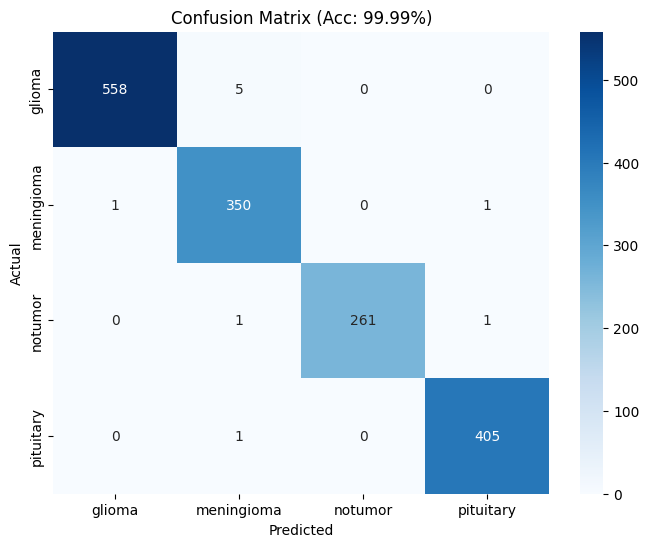

In [9]:
# Reload best model for final eval
with strategy.scope():
    best_model = tf.keras.models.load_model(Config.MODEL_PATH)

print("Evaluating on Test Set...")
loss, acc = best_model.evaluate(test_gen, verbose=1)
print(f"Test Accuracy: {acc:.4f}")

# Full Report
test_gen.reset()
preds = best_model.predict(test_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes
labels = list(test_gen.class_indices.keys())

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=labels))

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title(f'Confusion Matrix (Acc: {acc:.2%})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Generating predictions...
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 769ms/step
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1

Test Accuracy: 0.9999

Classification Report:
               precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       563
  meningioma       0.98      0.99      0.99       352
     notumor       1.00      0.99      1.00       263
   pituitary       1.00    

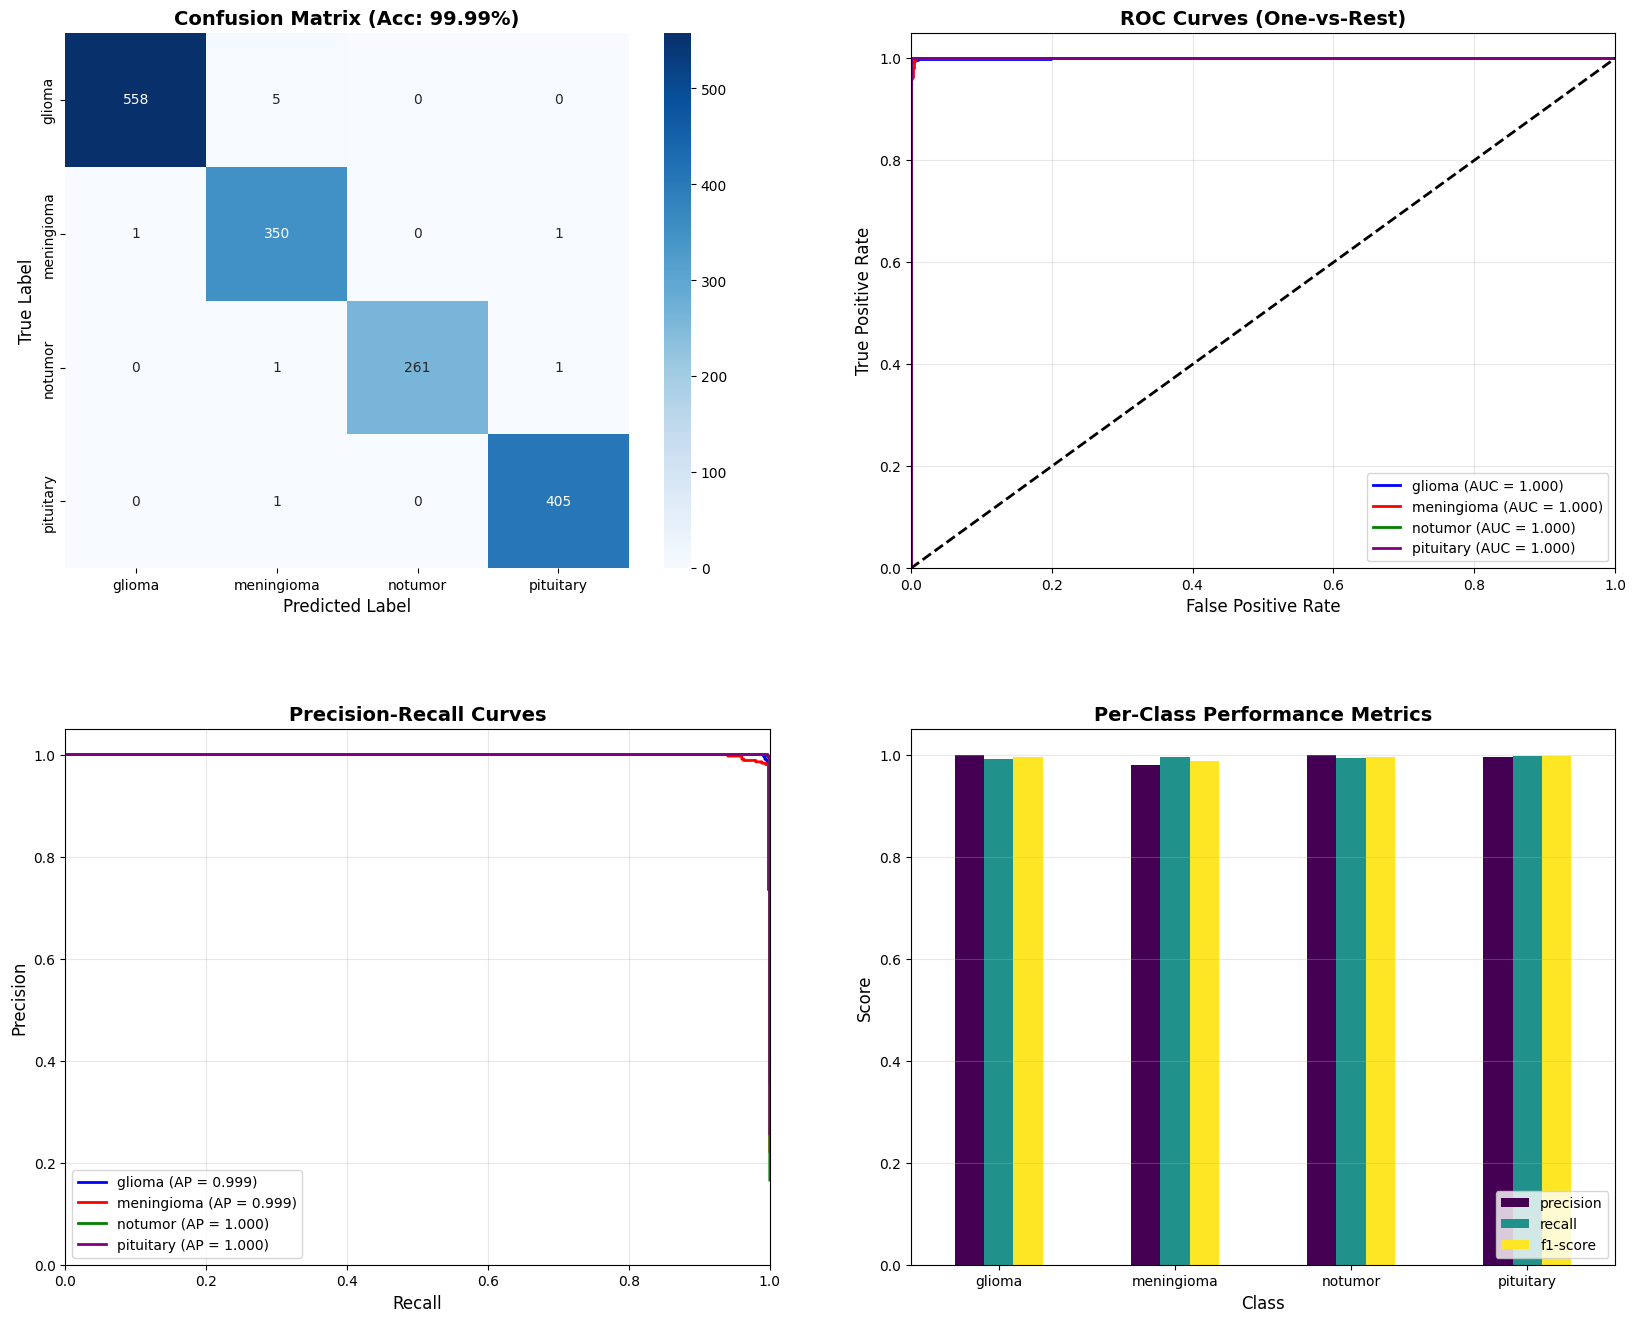

In [10]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from itertools import cycle

# --- 1. GET PREDICTIONS ---
# Load best model within strategy scope
with strategy.scope():
    best_model = tf.keras.models.load_model(Config.MODEL_PATH)

print("Generating predictions...")
test_gen.reset()
# Get raw probabilities (needed for ROC/PR curves)
y_pred_probs = best_model.predict(test_gen, verbose=1)
# Get hard predicted classes (needed for Confusion Matrix & Report)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
# Get true labels
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())
n_classes = len(class_names)

# --- 2. CALCULATE METRICS ---
# Overall Test Score
test_loss, test_acc = best_model.evaluate(test_gen, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Print Text Report
report = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))

# --- 3. PREPARE DATA FOR ADVANCED PLOTS ---
# Binarize the labels for multi-class ROC/PR
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# --- 4. PLOTTING ---
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

# Plot A: Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
            xticklabels=class_names, yticklabels=class_names)
axes[0,0].set_title(f'Confusion Matrix (Acc: {test_acc:.2%})', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Predicted Label', fontsize=12)
axes[0,0].set_ylabel('True Label', fontsize=12)

# Plot B: ROC Curves (One-vs-Rest)
colors = cycle(['blue', 'red', 'green', 'purple'])
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    axes[0,1].plot(fpr, tpr, color=color, lw=2,
                   label=f'{class_names[i]} (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], 'k--', lw=2)
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate', fontsize=12)
axes[0,1].set_ylabel('True Positive Rate', fontsize=12)
axes[0,1].set_title('ROC Curves (One-vs-Rest)', fontsize=14, fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# Plot C: Precision-Recall Curves
for i, color in zip(range(n_classes), colors):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
    avg_precision = average_precision_score(y_true_bin[:, i], y_pred_probs[:, i])
    axes[1,0].plot(recall, precision, color=color, lw=2,
                   label=f'{class_names[i]} (AP = {avg_precision:.3f})')
axes[1,0].set_xlabel('Recall', fontsize=12)
axes[1,0].set_ylabel('Precision', fontsize=12)
axes[1,0].set_title('Precision-Recall Curves', fontsize=14, fontweight='bold')
axes[1,0].legend(loc="lower left")
axes[1,0].grid(True, alpha=0.3)
axes[1,0].set_xlim([0.0, 1.0])
axes[1,0].set_ylim([0.0, 1.05])

# Plot D: Per-Class Performance Metrics Bar Chart
metrics_df = pd.DataFrame(report).transpose().iloc[:-3, :3] # Exclude 'accuracy', 'macro avg', 'weighted avg'
metrics_df.plot(kind='bar', ax=axes[1,1], colormap='viridis')
axes[1,1].set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Class', fontsize=12)
axes[1,1].set_ylabel('Score', fontsize=12)
axes[1,1].set_ylim([0.0, 1.05])
axes[1,1].legend(loc='lower right')
axes[1,1].grid(axis='y', alpha=0.3)
plt.setp(axes[1,1].get_xticklabels(), rotation=0)

plt.show()